In [12]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw2.ipynb")

# CS1090A Introduction to Data Science
## Homework 2: kNN, Linear/Polynomial Regression, Regularization, and Model Selection

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb

<hr style="height:2.4pt">

In [13]:
# RUN THIS CELL 
from IPython.core.display import HTML

# Define custom CSS for the notebook
styles = """
<style>
    h2, h3, h4 {
        color: black;
        border: 1px solid #e0e0e0;
        border-radius: 5px;
        padding: 10px 15px;
        margin-top: 20px;
        margin-bottom: 10px;
        font-weight: bold;
    }
    h2 { background-color: #C8A2C8; } /* Lilac */
    h3 { background-color: #D8BFD8; } /* Thistle */
    h4 { background-color: #E6E6FA; } /* Lavender */
</style>
"""
HTML(styles)

### Import Libraries

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import time

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

In [15]:
# For calculating total notebook runtime
notebook_start = time.time()

## About this homework

This assignment is the first in which we'll go through the full process of loading a dataset, performing exploratory data analysis (EDA), splitting the data into training, validation, and test sets, and finally fitting and evaluating models. You can use the table of contents panel in your Jupyter environment (e.g., JupyterLab or Colab) to navigate between sections.

The homework is divided into three parts, each using a different dataset:

-   **Part 1: Predicting Car Prices**
    Explore two fundamental modeling techniques: k-Nearest Neighbors (kNN) regression, a non-parametric method, and simple linear regression, a parametric method. Use a validation set to tune the hyperparameter `k` for the kNN model.

-   **Part 2: Analyzing Simulated Income Data**
    Practice exploratory data analysis (EDA) and data critique. Create insightful visualizations to explore relationships in a simulated US census dataset and calculate the Gini coefficient to measure income inequality.

-   **Part 3: Modeling Bacteria Growth**
    Dive deeper into model selection and the bias-variance tradeoff. Using polynomial regression, explore how model complexity (the degree of the polynomial) impacts performance. Compare two common techniques for hyperparameter tuning and model selection—using a single validation set versus k-fold cross-validation—to find a model that generalizes well and avoids overfitting.

<div style="background-color: #E6E6FA; color: black; border: 1px solid #e0e0e0; border-radius: 5px; padding: 10px 15px;">

### Instructions

**Submission Checklist**
- **Run All Cells:** Before submitting, always do **"Restart Kernel and Run All Cells"** to ensure your notebook runs top-to-bottom without errors and all output is visible.
- **Submission:** Follow the submission instructions described in the Canvas assignment.

**General Guidelines**
- **Limit Output:** Avoid excessively long cell outputs.
- **Clarity:** Plots must be legible and well-labeled. Written interpretations should explain what the results *mean*, not just describe them.
- **Code Quality:** Write clean and efficient code. Avoid copy-pasting; use loops or functions instead.
- **Libraries:** Use only the provided libraries unless you get staff approval.
- **Autograding:** The provided tests are not exhaustive. Passing all tests does not guarantee full credit.
- **Cell Management:** Feel free to add new cells as needed.

</div>

<a id="part1"></a>
    
# PART 1 [35 pts]: Predicting the selling price of cars on CarDekho.com

<a id="part1intro"></a>

## Overview

According to its website, **CarDekho.com** is India's leading car search venture. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons, as well as videos and pictures of all car brands and models available in India. Each car has a **current selling price**, which is the price for buying a used car on this site, and an **MRP**, which is the retail price of the car. These two prices differ depending on factors such as brand, make year, mileage, condition, etc.  

### Dataset 

The dataset contains 601 used cars and is available as `data/car_dekho_full.csv`. It contains the following columns:

- **Year** - make year (year the car was made), 
- **Current_Selling_Price** - current price of a used car on CarDekho.com (in lakhs),
- **MRP** - maximum retail price of the car when it was new (in lakhs). 
- **Kms_Driven** - number of kilometers

**NOTE:** 1 *lakh*  is 100,000 Rupees in the Indian numbering system. Also, kilometers are used as a measure of distance instead of miles.

### Objective

Using kNN and linear regression we will predict the `Current_Selling_Price` from the other features available in this dataset.

<a id="part1questions"></a>

## Question 1: Exploratory data analysis (EDA) [5 pts]

To reach the goal of predicting the `Current_Selling_Price`, start by inspecting the dataset using Exploratory Data Analysis (EDA).

**Load the dataset, inspect it, and answer the following questions:**

<!-- BEGIN QUESTION -->

### Q1.1

Identify all variables in the dataset. For each variable, state whether you consider it to be quantitative or categorical and briefly justify your choices.

_Type your answer here, replacing this text._

In [16]:
df = pd.read_csv("data/car_dekho_full.csv")
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Year,601.0,2013.887,2.721,2003.00,2012.00,2015.00,2016.0,2018.00
Current_Selling_Price,601.0,4.393,4.518,0.12,1.05,3.60,5.8,33.00
MRP,601.0,6.912,6.480,0.32,1.47,6.05,9.4,36.23
Kms_Driven,601.0,33718.745,26846.657,500.00,15000.00,30000.00,46500.0,213000.00


In [17]:
df.isnull().sum()

Year                     0
Current_Selling_Price    0
MRP                      0
Kms_Driven               0
dtype: int64

In [18]:
df.head()

,Year,Current_Selling_Price,MRP,Kms_Driven
0,2016,5.25,5.70,3493
1,2005,3.51,13.70,75000
2,2010,0.31,1.05,213000
3,2006,2.10,7.60,50456
4,2005,0.20,0.57,55000


Year is a quantitative predictor because the age of the car, which is calculated from the year, can affect the price of the car.

Current_Selling_Price is a quantitative variable because we can use it to forecast other features of the car such as year, future selling price, e.t.c.

MRP is a quantitative predictor because we can use it to analyze average MRP by year and the relationship between MRP and Current Selling Price.

Kms_Driven is a quantitative predictor because it can influence the depreciation and resale value.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q1.2

The goal in this section is to identify the best feature to use to predict our response, `Current_Selling_Price`. 

- Plot a scatter plot of each feature and our reponse and examine any relationships.
- Which is the predictor that seems to best predict `Current_Selling_Price`? Provide an interpretation of the plots that justifies your choice.

_Type your answer here, replacing this text._

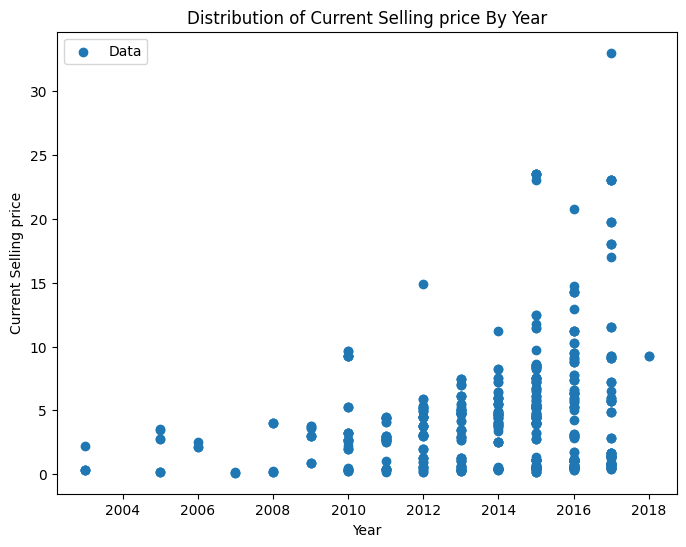

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Year"], df["Current_Selling_Price"], label="Data")
plt.xlabel("Year")
plt.ylabel("Current Selling price")
plt.title("Distribution of Current Selling price By Year")
plt.legend()
plt.show()

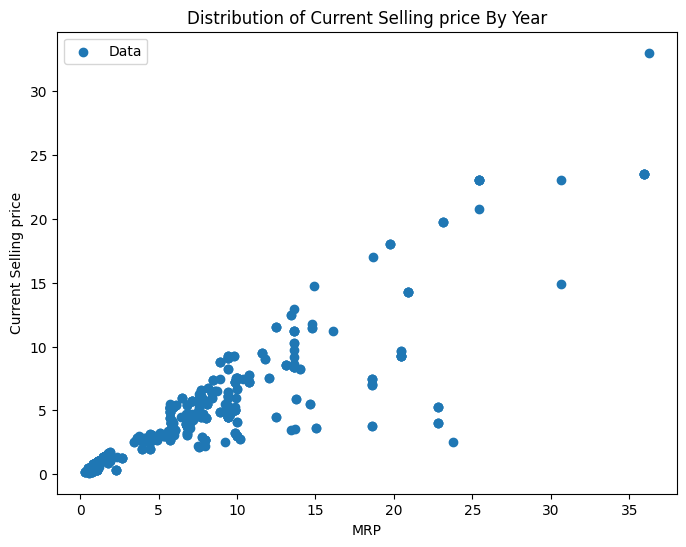

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(df["MRP"], df["Current_Selling_Price"], label="Data")
plt.xlabel("MRP")
plt.ylabel("Current Selling price")
plt.title("Distribution of Current Selling price By Year")
plt.legend()
plt.show()

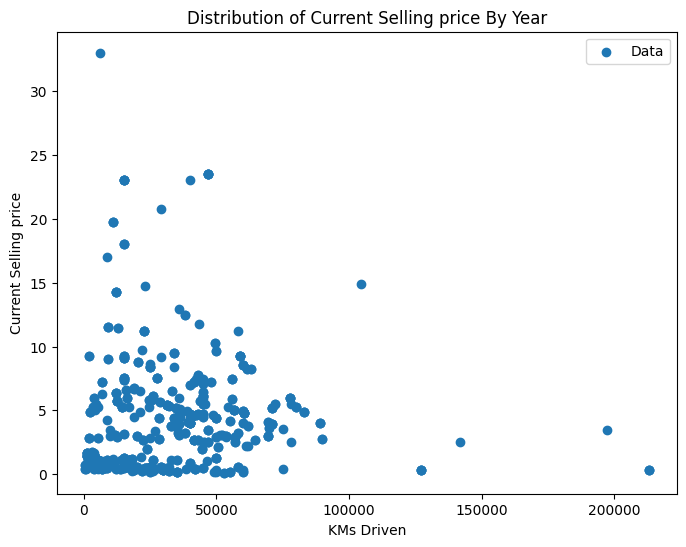

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Kms_Driven"], df["Current_Selling_Price"], label="Data")
plt.xlabel("KMs Driven")
plt.ylabel("Current Selling price")
plt.title("Distribution of Current Selling price By Year")
plt.legend()
plt.show()

From all the plots, we can see that MRP is a better predictor of the Current_Selling_Price. The plot of Distribution of Current Selling Price by MRP shows clearly how current selling price changes with MRP. With the Distribution of Current Selling Price by Year and Distribution of Current Selling Price by KMs Driven, it's not clear how Year or KMs Driven affect current selling price.

<!-- END QUESTION -->

<a id="part2questions"></a>

## Question 2: k-Nearest Neighbors [14 pts]

We will begin our modeling with k-Nearest Neighbors (kNN) regression, using `sklearn` for both preprocessing and model fitting.

### Q2.1

Split the dataset into a train, validation, and test set with 60% training data, 20% validation data, and 20% testing data, using argument `random_state = 109`.

The resulting splits should be stored in the variables:

- `X_train_and_val`, `X_test`, `y_train_and_val`, `y_test` (from the first split)  
- `X_train`, `X_val`, `y_train`, `y_val` (from the second split)

In [26]:
y = df["Current_Selling_Price"]
x = df.drop("Current_Selling_Price", axis=1)

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(
    x,
    y,
    random_state=109,
    test_size=0.2,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val,
    y_train_and_val,
    random_state=109,
    test_size=0.25,
)

In [27]:
grader.check("q2.1")

q2.1 results: All test cases passed!

### Q2.2

Now, we will fit several kNN regression models for various values of $k$ to identify the best parameterization.

<!-- BEGIN QUESTION -->

#### Q2.2.1

For each $k$ in $k \in [1,2,3,5,7,10,50,100]$, fit a k-NN regression model to the training data with response `Current_Selling_Price` and the predictor `MRP`. 
  - For each $k$, make a plot of reponse vs. predictor (8 plots in total, arranged in a 4×2 grid). 
  - Each of your 8 plots should clearly show (a) the training data and the validation data in different colors, (b) the model prediction, and (c) title, legend, and axis labels.
  - **NOTE:** Feel free to use the `plt.subplots()` code we provide to specify your 4x2 grid, unless you first try that and decide that you have a clearer, cleaner way of accomplishing this task.

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q2.2.2

Plot the training and validation $MSE$ values as a function of $k$ (1 plot in total).

In [ ]:
# your code here

<!-- END QUESTION -->

#### Q2.2.3

Find the best model based on the validation $MSE$ values. Store the best $k$-value in `best_k` and the best validation $MSE$ in `best_mse`.

In [ ]:
# your code here
best_k = ...
best_mse = ...

In [ ]:
print(
    f"The best k value is {best_k}. This corresponds to the "
    f"lowest validation MSE of {best_mse:.3f}."
)

In [ ]:
grader.check("q2.2.3")

#### Q2.2.4

Now that you've chosen your best k, fit your final model and report the test $R^2$. Save the result in `best_r2`. **Hint:** why might you need to fit the model again before evaluating on the test set?

In [ ]:
# your code here
best_r2 = ...
knn_test_mse = ...

In [ ]:
print(
    f"The R-squared score evaluated on the test set for the best model "
    f"with k={best_k} is {best_r2:.4f}."
    f"\nThe test MSE is {knn_test_mse:.4f}."
)

In [ ]:
grader.check("q2.2.4")

<a id="part3questions"></a>

## Question 3: Simple linear regression [16 pts]

### Q3.1

We will now fit our data using a linear regression model. Choose the same **predictor** and **response** variables you used in the kNN model. Use a 75% training and 25% testing split of the data, using `random_state = 109`.

For a fair comparison with the kNN model, we will use the same train/test split from Q2.
Since our simple linear regression model does not require a validation set for hyperparameter tuning, we can train it on the combined training and validation data.

In [ ]:
X_train, y_train = X_train_and_val, y_train_and_val

The variables X_test and y_test are already defined from the split in Q2.1 and will be used for testing.

#### Q3.1.1

Fit a linear regression model. Name your model `linreg`.

In [ ]:
# your code here
# Instantiate a LinearRegression class object and fit with train data
linreg = ...

In [ ]:
grader.check("q3.1.1")

#### Q3.1.2

Report the slope and intercept values for the fitted linear model. Name your variables `slope` and `intercept`.

In [ ]:
# your code here
slope = ...
intercept = ...

In [ ]:
print(
    f"Intercept of the fitted linear model\t\t{intercept:.4f}\n"
    f"Slope of the fitted linear model\t{slope:.4f}"
)

In [ ]:
grader.check("q3.1.2")

#### Q3.1.3

Report the $MSE$ for the training and test sets and the $R^2$ for the test set. Name your variables `lin_train_mse`, `lin_test_mse`, and `lin_test_r2`.

In [ ]:
# your code here 
#Compute the MSE of the model
lin_train_mse = ...
lin_test_mse = ...
#Compute the R-squared of the model
lin_test_r2 = ...

In [ ]:
print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        lin_train_mse,
        lin_test_mse,
    )
)

print(f"\tTest R-squared\t{lin_test_r2:.4f}")

In [ ]:
grader.check("q3.1.3")

<!-- BEGIN QUESTION -->

#### Q3.1.4

Create the following 3 plots:
- Plot the **regression line** along with the **training data**.
- Plot the **residuals** of the model on the **training** set as a function of the **predictor** variable. Draw a horizontal line denoting the zero residual value on the $y$-axis.
- Plot a the **distribution** of the **residuals** on the **training** set.

As always, your plots should be well-labeled.

In [ ]:
# your code here 

<!-- END QUESTION -->

### Q3.2
Answer the following questions about your results:

<!-- BEGIN QUESTION -->

#### Q3.2.1

A linear regression model makes four important assumptions. For each assumption, describe how one or more of the plots in the previous question may provide evidence that (1) the assumption holds, (2) the assumption is violated, or (3) the plots do not provide enough evidence. In the latter case, suggest an additional diagnostic plot(s) or test(s) that could be used to evaluate the assumption.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

 
#### Q3.2.2
Based on your findings in Q3.2.1, identify the most significant assumption violation. Propose and implement a modified linear regression model that is designed to address this specific issue. Fit your new model and report its train and test MSE. In your explanation, justify why this modeling adjustment is appropriate for the violation you observed.

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q3.2.3

Based on your results, which model would you select as the best for predicting car prices? Justify your choice by comparing their performance on the test set. Is your chosen model a "good" model? Explain why or why not, and discuss any reasons you might have to doubt your choice.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [32 pts]: Analysis of 2024 US Annual Social and Economic (ASEC) Supplement

<a id="part2intro"></a>

## Overview

In this part we analyze *simulated* income data from the publically available 2024 US Annual Social and Economic (ASEC) Supplement (https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html), provided by the US Census Bureau. The Current Population Survey (CPS) has been conducted monthly for over 50 years. Currently, about 54,000 households are interviewed monthly, scientifically selected on the basis of area of residence to represent the nation as a whole, individual states, and other specified areas. 

### Dataset

The simulated data can be found in `data/census_data.csv`.

The number of features have been greatly reduced from the original dataset. You can see the description of the original dataset in the [ASEC data dictionary](https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf).

In addition to subsetting the features, other preprocessing steps have been taken. For example, some categorical variables have had their number of unique values reduced. 

We refer to the data as *simulated* because sampling was used to turn what was originally an ordinal response variable (42 income brackets) into something more continous.

Considering this, the results of your analysis should be viewed skeptically. You can view the the preprocessing steps taken to create the simplified, simulated data in `data/preprocessing.ipynb`.

**NOTE:** Variables have been renamed for easier interpretation. You can find the original variable names in the preprocessing notebook. It will be these original variable names that appear in the data dictionary linked above.

### Features
- **age** - Age of person 
- **hourly_pay** - Hourly salary of person (-1 if person is not payed by the hour)
- **hours_per_week** - Number of hours usually worked per week
- **weeks_worked** - Number of weeks worked per year

- **sex** - {'Female': 0,'Male': 1} 
- **marital_status** - {'married':0,'widowed':1,'Divorced':2, 'Separated':3,'Never married':4}
- **military_service** - {'has not served in the US armed forces':0,'has served in the US armed forces':1}
- **student_status** - {'Not currently studying':0,'Enrolled full-time':1, 'Enrolled part-time':1}
- **education** - {'Not finished high school': 0, 'High school': 1, 'Associate degree': 2, 'Bachelor\'s': 3, ,'Master\'s': 4,'Professional school degree': 5', Doctorate': 6}

- **race** - {'White': 0, 'Black': 1, 'American Indian, Alaskan Native only (AI)': 2, 'Asian': 3, ,'Hawaiian, Pacific Islander (HP)': 4,'White-Black': 5', 'White-AI': 6, 'White-Asian': 7, 'White-HP': 8, 'Black-AI': 9, 'Black-Asian': 10, 'Black-HP': 11, 'AI-Asian': 12, 'AI-HP': 13, 'Asian-HP': 14, 'other race combinations': 15}

- **industry** - Industry that the person is working in {'Other': 0, 'Agriculture, forestry, fishing, hunting': 1, 'Mining': 2, 'Construction': 3, ,'Manufacturing': 4,'Wholesale and retail trade': 5','Transportation and utilities': 6, 'Information': 7, 'Financial activities': 8, 'Professional and business services': 9, 'Education and health services': 10, 'Leisure and hospitality': 11, 'Other services': 12, 'Public administration': 13, 'Armed Forces': 14}

- **occupation** - Occupation of person {'Other': 0, 'Management, business, and financial occ.': 1, 'Professional and related occ.': 2, 'Service occ.': 3, ,'Sales and related occ.': 4,'Office and administrative support occ.': 5','Farming, fishing and forestry': 6, 'Construction and extraction occ.': 7, 'Installation, maintenance and repair occ.': 8, 'Production occ.': 9, 'Transportation and material moving occ.': 10, 'Armed Forces': 11}


- **income** - Annual income in dollars

<a id="part4questions"></a>

## Question 4: Investigating trends [18 pts]

Below we'll answer questions about potential trends in the data with the help of plots and/or simple statistics. Your goal should be to communicate your findings clearly. So be sure to provide an interpretation with your visualizations or other output.

In [ ]:
df = pd.read_csv("data/census_data.csv", index_col=0)
df.head()

<!-- BEGIN QUESTION -->

### Q4.1

Is there a disparity in income of participants by gender? Consider using a log scale or another technique when plotting to communicate findings more clearly.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.2

Let's investigate a few questions about education and income:
- Is there a relationship between income and education level? 

- Is this trend similar across both genders in the dataset? 

- Is it possible to consider education level as an ordinal variable? For instance, consider whether retaining the numerical ordering in the dataset might be preferable to education level as a categorical variable lacking order.

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.3

Is there a clear trend between age and income?

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.4

Do any of the quantitative attributes show a clear relationship with income? If so, are these relationships linear or non-linear?

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.5

Fit a simple linear regression model to explore the relationship between `military_service` and `income`. Based on your model, what is the estimated average difference in income for those with prior military service? What are some important limitations to consider when interpreting this result?

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4.6

Propose a question of your own that you would like to explore in the data. Create a visualization to help you answer this question and provide an interpretation of your findings.

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<a id="part5questions"></a>

## Question 5: Calculate the Gini coefficient [8 pts]


**Gini coefficients are often used to quantify income inequality.** For an introductory overview of the Gini coefficient, its derivation, and its uses, you can [read more about it here](https://en.wikipedia.org/wiki/Gini_coefficient). That article also provides [a useful graphical representation](https://en.wikipedia.org/wiki/File:Economics_Gini_coefficient2.svg) of the Gini coefficient to better understand how it measures inequality. 

The Gini coefficient is defined by the formula:

$$G = \dfrac{ \sum_{i=1}^{n} (2i - n - 1) x_i}{n  \sum_{i=1}^{n} x_i}$$

where $x$ is an observed value, $n$ is the number of values observed and $i$ is the rank of values in **ascending** order.

A Gini coefficient of $G=0$ implies perfect income equality, whereas a Gini coefficient close to $G=1$ implies a concentration of wealth among the richest few.

### Q5.1

Based on the above formula, calculate and report the Gini coefficient for the income of those people in the the provided ASEC dataset. Store the result in `gini_coef`.

- **NOTE:** For algorithmic simplicity and consistency, you can rank income values for all observations, keeping duplicate values in your sorted array. Therefore, you will likely have sorted income values $x_i$ similar to `[417, 417, 417, ..., 250000, 250000, 250000]` with corresponding rank indices $i$ similar to `[1, 2, 3, ..., 12353, 12354, 12355]`. Nothing more sophisticated than that is required for dealing with ties (i.e. duplicates) in your sorted income values for Question 5.1.

In [ ]:
# your code here
gini_coef = ...

In [ ]:
# Print resulting Gini coefficient
print(f"The Gini Index for this dataset is {gini_coef:.3f}")

In [ ]:
grader.check("q5.1")

<!-- BEGIN QUESTION -->

### Q5.2

According to the [World Bank estimate](https://www.indexmundi.com/facts/indicators/SI.POV.GINI/rankings) the country with the largest Gini coefficient is South Africa, ranked 1st at $0.63$, while the lowest is the Slovak Republic, ranked 162nd at $0.232$. The United States is ranked 46th on the list and has a Gini index of $0.415$.

- How well does your calculated Gini coefficient for this simulated dataset match the world bank estimate?

- Might the self-report nature of the data, preprocessing steps, or simulation (i.e., sampling) procedure have affected your results? If so, how?

**Note:** The World Bank estimate website uses a [0,100] range for the Gini Index. Above we have converted this to a [0,1] range.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6questions"></a>

## Question 6: Critiquing the simulated data [6 pts]

Take a look at both the [data dictionary for the original dataset](https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf) and the notebook used to create the simplified simulation, `data/preprocessing.ipynb`. 

What might you have done differently were you to write your own preprocessing code?
A nonexhaustive list of a few things to consider would be:
- Are there important features you think should have been included that were not? 
- Do you agree with the methods used to reduce the number of unique categorical values?
- Might there be a better way to simulate a continuous response from the discrete income brackets in the original data?

**Note:** We used the record type 'person' data from the ASEC rather than 'household' or 'family.' All three record types are represented in the data dictionary.

> **Note**: The rubric below is provided for transparency. Please ensure your responses are genuine and thoughtful, rather than simply attempting to "fit" the rubric.
---
<details>
<summary><b>Click to view the Q6 Critique Rubric</b></summary>
    
### Q6 Critique Rubric:

**Total Points: 10**

#### 1. Relevance of Comments (4 points):
- **4 points**: The critique directly addresses specific sections or steps in the preprocessing notebook, demonstrating a thorough understanding of the content.
- **3 points**: The critique references multiple sections of the notebook with some specificity.
- **2 points**: The critique generally addresses the notebook but may lack specific references to steps or sections.
- **1 point**: The critique provides only a cursory overview without specific details.
- **0 points**: The critique does not address the preprocessing notebook.

#### 2. Depth of Analysis (4 points):
- **4 points**: The student provides deep insights, identifies potential pitfalls, or suggests meaningful improvements for multiple sections of the notebook.
- **3 points**: The student provides valuable feedback for one section or multiple but less detailed feedback for several sections.
- **2 points**: The analysis is somewhat detailed but may lack depth or actionable feedback.
- **1 point**: The feedback is generic or surface-level.
- **0 points**: No meaningful analysis provided.

#### 3. Clarity and Organization (2 points):
- **2 points**: The critique is well-organized, clear, and easy to follow.
- **1 point**: The critique is somewhat organized but may have unclear sections.
- **0 points**: The critique is disorganized or difficult to understand.

---

Remember to provide specific examples or suggestions whenever possible. General statements without backing evidence or examples will not be as valuable as those with clear references and reasoning.

</details>

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<a id="part3"></a>
    
# PART 3 [33 pts]: Predicting percentage change in bacteria populations given their spread factor

<a id="part3intro"></a>

## Overview

For this part, we will explore polynomial regression for modeling a quantitative variable. Specifically, we will model the percent change in a bacteria population after 4 hours as a function of the bacteria's "spreading factor".

**The data set for this problem has already been split for you.** You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively.

### Problem Description

We will predict the percentage change in population, given the spreading factor. Thus, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. Using mean squared error ($MSE$) as an evaluative criteria, we will explore several different approaches for finding the best fit and most robust polynomial regression for modeling this relationship.

<a id="part7questions"></a>

## Question 7: Guesstimate the polynomial relationship [7 pts]

<!-- BEGIN QUESTION -->

### Q7.1

Generate a well-labeled scatter plot of the data points in the bacteria_train.csv file with the spreading factor on the 
x-axis and the percentage change on the y-axis.

Based on your inspection of the plot, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. 

**Notes:**
- **You don't need to scale your data in this assignment** (you can inspect the data to see why this might not be necessary)
- **You should *not* include a bias in the design matrix you intend to pass to the linear regression's `fit` method.**

In [ ]:
# your code here

In [ ]:
grader.check("q7.1")

<!-- BEGIN QUESTION -->

### Q7.2

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '7.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

**Hint:** Because you will be calculating MSEs for models through this notebook, you may want to abstract this process into a function for re-use.

In [ ]:
# Fit a linear regression model
# your code here

In [ ]:
# Display your results thus far.
pd.DataFrame(results)

In [ ]:
grader.check("q7.2")

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q7.3

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.

_Type your answer here, replacing this text._

In [ ]:
# your code here

In [ ]:
# your code here

<!-- END QUESTION -->

<a id="part8questions"></a>

## Question 8: Single validation set [12 pts]

In this section you'll find the best degree polynomial relationship using a single validation set.

<!-- BEGIN QUESTION -->

### Q8.1

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

In [ ]:
# your code here

In [ ]:
grader.check("q8.1")

<!-- BEGIN QUESTION -->

### Q8.2

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

In [ ]:
# your code here

In [ ]:
grader.check("q8.2")

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q8.3

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful.

In [ ]:
# your code here

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q8.4

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

In [ ]:
# your code here

In [ ]:
# Display your results thus far.
pd.DataFrame(results)

In [ ]:
grader.check("q8.4")

<!-- BEGIN QUESTION -->

### Q8.5

Generate a plot of the data and your regression curve (similar to [Question 7.3](#part7questions)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from Question 7.

In [ ]:
# your code here

<a id="part9questions"></a>

## Question 9: Finding the best model by k-fold cross validation [14 pts]

<!-- BEGIN QUESTION -->

### Q9.1

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`

In [ ]:
# your code here

In [ ]:
grader.check("q9.1")

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.2

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 9.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.3

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 9.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list.

In [ ]:
# your code here

In [ ]:
grader.check("q9.3")

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

### Q9.4

- Generate a plot of the data and your regression curve (similar to [Question 7.3](#part7questions)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 8](#part8questions).

_Type your answer here, replacing this text._

In [ ]:
# your code here

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

## Wrap-up

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("wrapup")

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

🌈 **This concludes HW2. Thank you!**